Importing Libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from IPython.display import Markdown, display
import numpy as np
%pip install -q tensorflow-recommenders
import tensorflow as tf
import tensorflow_recommenders as tfrs
def printmd(string):
    display(Markdown(string))

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Data Visualization

In [3]:
data=pd.read_csv("data.csv", dtype={'rating': 'int8'},
                             names=['userId', 'productId','rating','timestamp'], index_col=None, header=0)
data.head()

,userId,productId,rating,timestamp
0,A23LG3G7EBG2HU,B00001P4ZH,4,1201132800
1,AJNX64O7HYOKQ,B000FKBL6C,5,1178496000
2,A3RVJAU4BMSWPW,B00004WCIC,5,1242259200
3,AFHLI6TGUG6ZP,B000FOYMKU,4,1311811200
4,A1PH08VML4GC1G,B000FKYQFA,5,1225065600


In [4]:
printmd("**Number of Rating**: {:,}".format(data.shape[0]) )
printmd("**Columns**: {}".format( np.array2string(data.columns.values)) )
printmd("**Number of Users**: {:,}".format(len(data.userId.unique()) ) )
printmd("**Number of Products**: {:,}".format(len(data.productId.unique())  ) )

**Number of Rating**: 800,000

**Columns**: ['userId' 'productId' 'rating' 'timestamp']

**Number of Users**: 685,872

**Number of Products**: 170,244

In [5]:
data.describe()['rating'].reset_index()

,index,rating
0,count,800000.000000
1,mean,4.012335
2,std,1.381127
3,min,1.000000
4,25%,3.000000
5,50%,5.000000
6,75%,5.000000
7,max,5.000000


In [6]:
data_by_date = data.copy()
data_by_date.timestamp = pd.to_datetime(data.timestamp, unit="s")#.dt.date
data_by_date = data_by_date.sort_values(by="timestamp", ascending=False).reset_index(drop=True)
printmd("**Number of Ratings each day:**")
data_by_date.groupby("timestamp")["rating"].count().tail(10).reset_index()

**Number of Ratings each day:**

,timestamp,rating
0,2014-07-14,1080
1,2014-07-15,775
2,2014-07-16,653
3,2014-07-17,542
4,2014-07-18,544
5,2014-07-19,485
6,2014-07-20,513
7,2014-07-21,619
8,2014-07-22,575
9,2014-07-23,86


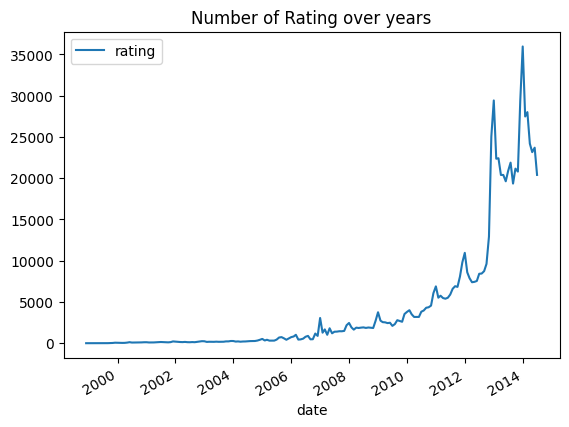

In [7]:
data_by_date["year"]  = data_by_date.timestamp.dt.year
data_by_date["month"] = data_by_date.timestamp.dt.month
rating_by_year = data_by_date.groupby(["year","month"])["rating"].count().reset_index()
rating_by_year["date"] = pd.to_datetime(rating_by_year["year"].astype("str")  +"-"+rating_by_year["month"].astype("str") +"-1")
rating_by_year.plot(x="date", y="rating")
plt.title("Number of Rating over years")
plt.show()

In [8]:
ratings = data.groupby("rating").agg({"rating":"count"})
ratings

,rating
rating,
1,92340
2,46448
3,64747
4,151934
5,444531


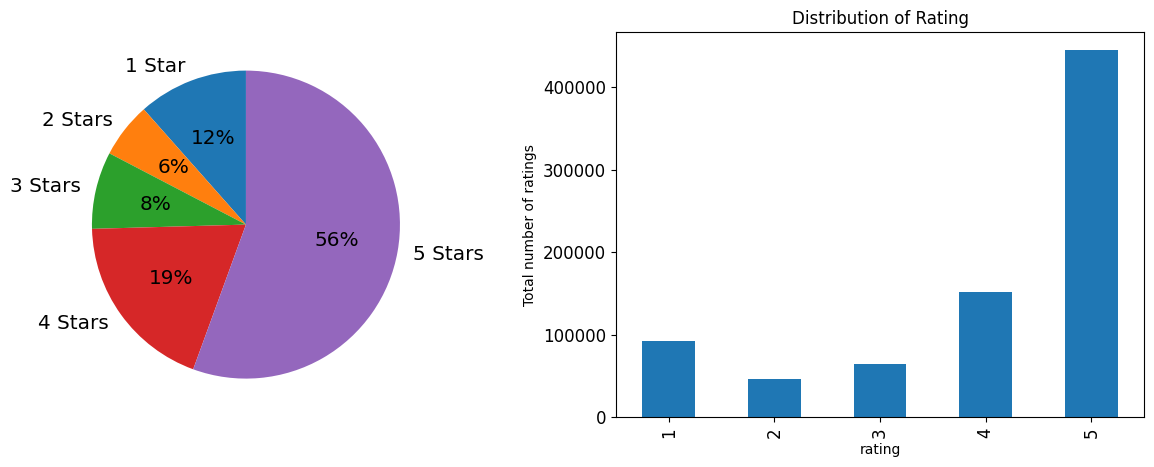

In [9]:
figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
ratings.plot.pie(ax=ax1,y="rating", legend=False, autopct='%1.f%%', startangle=90, fontsize="x-large", 
                 labels=["1 Star","2 Stars","3 Stars","4 Stars","5 Stars"])
ax1.set_ylabel('')
ratings.plot.bar(ax=ax2,  fontsize="large")
ax2.set(ylabel="Total number of ratings")
ax2.set(title="Distribution of Rating")
ax2.get_legend().remove()

plt.show()

In [10]:
rating_by_user = data.groupby(by='userId')['rating'].count().sort_values(ascending=False)

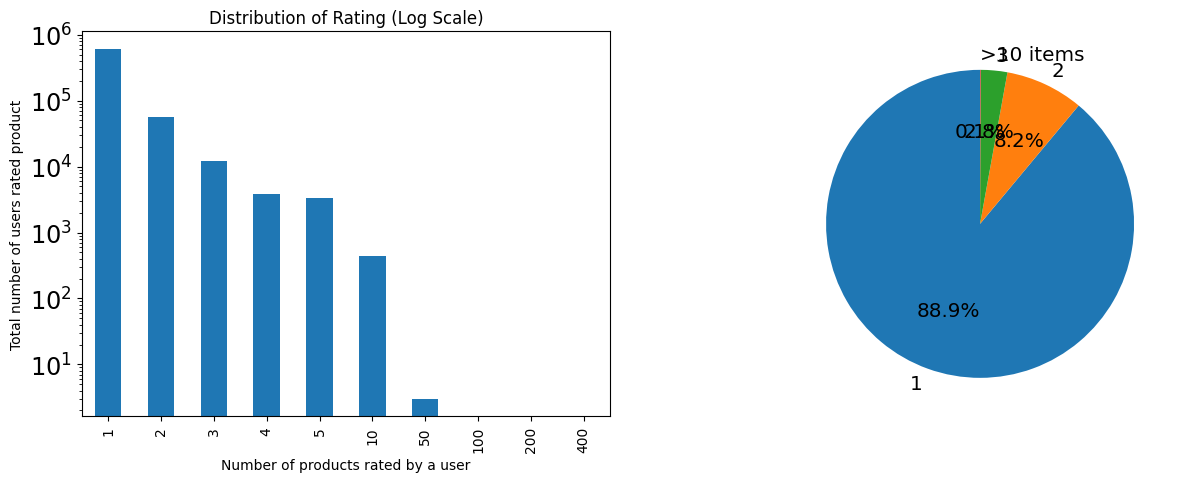

In [11]:
rating_hist,  bins  = np.histogram(rating_by_user, bins=[1,2,3,4,5,10,50,100,200,400,500])
rating_hist2, bins2 = np.histogram(rating_by_user, bins=[1,2,3,10,100000])
figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)

pd.DataFrame({"Numbers of User":rating_hist,"Total Rates":bins[:-1]}).plot.bar(x="Total Rates", ax=ax1)
ax1.set(yscale="log")
ax1.set(ylabel="Total number of users rated product", xlabel="Number of products rated by a user")
ax1.set(title="Distribution of Rating (Log Scale)")
ax1.get_legend().remove()
[item.set_fontsize("xx-large") for item in ax1.get_yticklabels()]

pd.DataFrame({"Numbers of User":rating_hist2,"Total Rates":bins2[:-1]}).plot.pie(x="Total Rates",y="Numbers of User",
              labels=[1,2,3,">10 items"], ax=ax2,legend=False, autopct='%1.1f%%', startangle=90, fontsize="x-large")
ax2.set_ylabel('')

plt.show()

In [12]:
rating_by_product = data.groupby("productId").agg({"userId":"count","rating":"mean"}).rename(
                        columns={"userId":"Number of Ratings", "rating":"Average Rating"}).reset_index()

In [13]:
printmd("**Top 10 products by Number of Rating**")
rating_by_product.sort_values(by="Number of Ratings",ascending=False ).reset_index(drop=True).head(10)

**Top 10 products by Number of Rating**

,productId,Number of Ratings,Average Rating
0,B00DR0PDNE,1922,3.948491
1,B0074BW614,1853,4.487318
2,B007WTAJTO,1432,4.391760
3,B0019EHU8G,1220,4.766393
4,B003ELYQGG,1195,4.394979
5,B006GWO5WK,1149,4.288077
6,B003ES5ZUU,1040,4.696154
7,B007R5YDYA,962,4.693347
8,B00622AG6S,954,4.430818
9,B0002L5R78,932,4.446352


In [14]:
rating_by_product.sort_values(by="Average Rating",ascending=False ).reset_index(drop=True).head(10)

,productId,Number of Ratings,Average Rating
0,0321732944,1,5.0
1,B004LNL6V4,1,5.0
2,B004LQ1C1K,1,5.0
3,B004LPM9YU,1,5.0
4,B004LPLE50,4,5.0
5,B004LPILLU,2,5.0
6,B004LPHKWG,2,5.0
7,B004LOFJPW,2,5.0
8,B004LNWMSA,1,5.0
9,B004LNVHUO,1,5.0


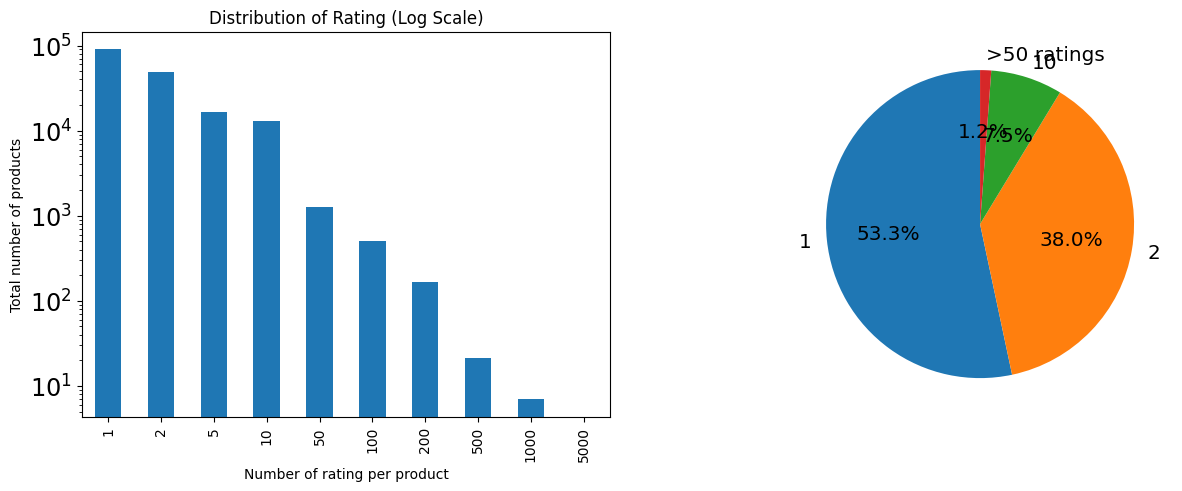

In [15]:
rating_hist,  bins  = np.histogram(rating_by_product["Number of Ratings"], bins=[1,2,5,10,50,100,200,500,1000,5000,10000])
rating_hist2, bins2 = np.histogram(rating_by_product["Number of Ratings"], bins=[1,2,10,50,100000])


figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)

pd.DataFrame({"Numbers of Products":rating_hist,"Total Rates":bins[:-1]}).plot.bar(x="Total Rates", ax=ax1)
ax1.set(yscale="log")
ax1.set(ylabel="Total number of products", xlabel="Number of rating per product")
ax1.set(title="Distribution of Rating (Log Scale)")
ax1.get_legend().remove()
[item.set_fontsize("xx-large") for item in ax1.get_yticklabels()]

pd.DataFrame({"Numbers of User":rating_hist2,"Total Rates":bins2[:-1]}).plot.pie(x="Total Rates",y="Numbers of User",
              labels=[1,2,10,">50 ratings"], ax=ax2,legend=False, autopct='%1.1f%%', startangle=90, fontsize="x-large")
ax2.set_ylabel('')

plt.show()

In [16]:
cutoff = 100
top_rated = rating_by_product.loc[rating_by_product["Number of Ratings"]>cutoff].sort_values(
                                by="Average Rating",ascending=False).reset_index(drop=True)

In [17]:
printmd("**Top 5 Products have the highest Ratings**")
top_rated.head(5)


**Top 5 Products have the highest Ratings**

,productId,Number of Ratings,Average Rating
0,B003XM9774,111,4.891892
1,B0043WJRRS,239,4.878661
2,B00D5Q75RC,324,4.827160
3,B003FVVMS0,171,4.818713
4,B007R5YGO2,142,4.816901


In [18]:
printmd("**With cutoff = {} we have only {:,} products.**".format(cutoff,top_rated.shape[0] ))
top_rated.describe()

**With cutoff = 100 we have only 692 products.**

,Number of Ratings,Average Rating
count,692.000000,692.000000
mean,206.752890,4.172104
std,179.189737,0.408707
min,101.000000,2.366906
25%,121.000000,3.973128
50%,154.000000,4.248209
75%,209.250000,4.451958
max,1922.000000,4.891892


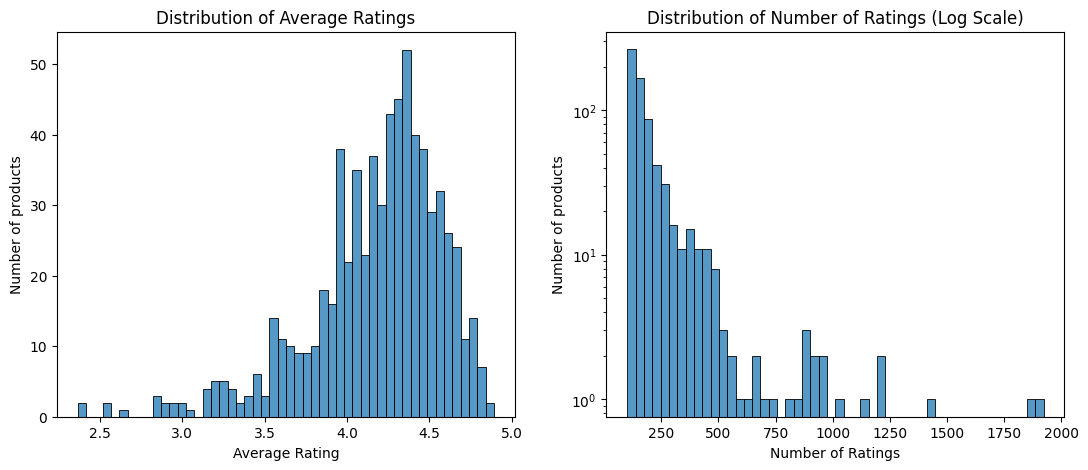

In [19]:
figsize = (13,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
sns.histplot(data=top_rated["Average Rating"], bins=50, ax=ax1)
ax1.set(title="Distribution of Average Ratings", ylabel="Number of products")

sns.histplot(data=top_rated["Number of Ratings"], bins=50, ax=ax2)
ax2.set(title="Distribution of Number of Ratings (Log Scale)")
ax2.set(yscale="log", ylabel="Number of products")
plt.show()

**Joint Graph**

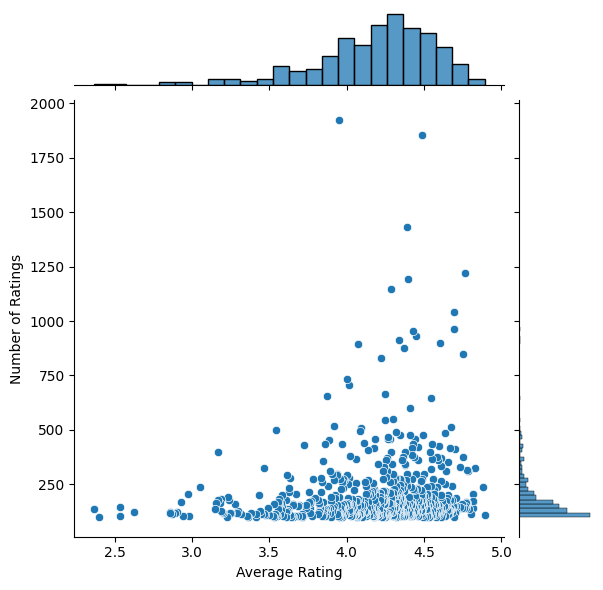

In [20]:
printmd("**Joint Graph**")
sns.jointplot(x='Average Rating', y='Number of Ratings', data=top_rated);

In [21]:
begin_date     = data_by_date.timestamp[0] - timedelta(days=30)
data_by_date30 = data_by_date.loc[ data_by_date.timestamp > begin_date  ]
products_30days= data_by_date30.groupby(["productId"]).agg({"rating":["mean","count"]}).droplevel(axis=1,level=0).reset_index()

<h3 style="color:red" >List of top products by number of rating </h3>

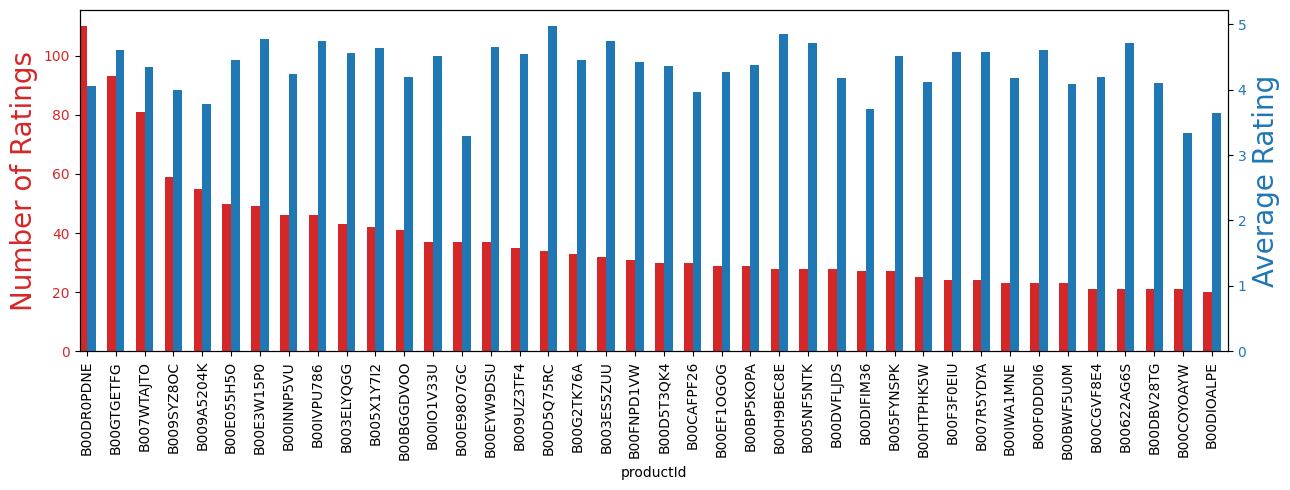

In [22]:
top_rated = products_30days.sort_values(by="count", ascending=False).head(40)

printmd('<h3 style="color:red" >List of top products by number of rating </h3>')
figsize = (13,5)
fig0, ax1 = plt.subplots(figsize=figsize)
ax2 = ax1.twinx()
top_rated.plot(kind = "bar",x="productId", y="count", 
                        ax=ax1,align='edge', color="tab:red", width=-0.3, legend=False)
top_rated.plot(kind = "bar",x="productId", y="mean", 
                        ax=ax2, align='edge',color="tab:blue", width=0.3, legend=False)
ax1.set_ylabel('Number of Ratings', color="tab:red", fontsize=20)
ax1.tick_params(axis='y', labelcolor="tab:red")
ax2.set_ylabel('Average Rating', color="tab:blue", fontsize=20)
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.tight_layout()
plt.show()

<h3 style="color:red" >List of top products by Average Rating </h3>

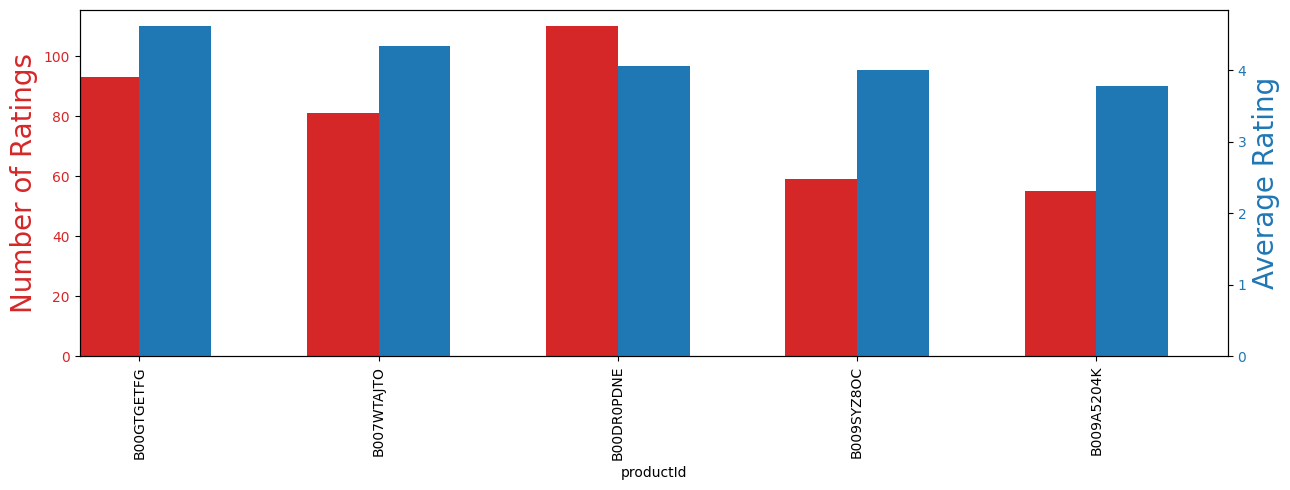

In [23]:
top_rated = products_30days.loc[products_30days["count"] > 50].sort_values(by="mean", ascending=False).head(40)

printmd('<h3 style="color:red" >List of top products by Average Rating </h3>')
figsize = (13,5)
fig0, ax1 = plt.subplots(figsize=figsize)
ax2 = ax1.twinx()
top_rated.plot(kind = "bar",x="productId", y="count", 
                        ax=ax1,align='edge', color="tab:red", width=-0.3, legend=False)
top_rated.plot(kind = "bar",x="productId", y="mean", 
                        ax=ax2, align='edge',color="tab:blue", width=0.3, legend=False)
ax1.set_ylabel('Number of Ratings', color="tab:red", fontsize=20)
ax1.tick_params(axis='y', labelcolor="tab:red")
ax2.set_ylabel('Average Rating', color="tab:blue", fontsize=20)  
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.tight_layout()
plt.show()

Making Model and tuning hyperparameters

In [24]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        self.user_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_userIds, mask_token=None),
                                    tf.keras.layers.Embedding(len(unique_userIds)+1, embedding_dimension)
                                    ])

        self.product_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_productIds, mask_token=None),
                                    tf.keras.layers.Embedding(len(unique_productIds)+1, embedding_dimension)
                                    ])
        self.ratings = tf.keras.Sequential([
                            # tf.keras.layers.Dense(2048, activation="relu"),
                            tf.keras.layers.Dense(1024, activation="relu"),
                            tf.keras.layers.Dense(512,  activation="relu"),
                            tf.keras.layers.Dense(256,  activation="relu"),
                            tf.keras.layers.Dense(128,  activation="relu"),
                            tf.keras.layers.Dense(64,  activation="relu"),
                            # tf.keras.layers.Dense(32,  activation="relu"),
                            tf.keras.layers.Dense(1)
                              ])
    def call(self, userId, productId):
        user_embeddings  = self.user_embeddings (userId)
        product_embeddings = self.product_embeddings(productId)
        return self.ratings(tf.concat([user_embeddings,product_embeddings], axis=1))


In [25]:
class FModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer   = tfrs.tasks.Ranking(
                                                    loss    =  tf.keras.losses.MeanSquaredError(),
                                                    metrics = [tf.keras.metrics.RootMeanSquaredError()])
            

    def compute_loss(self, features, training=False):
        rating_predictions = self.ranking_model(features["userId"], features["productId"]  )

        return self.task( labels=features["rating"], predictions=rating_predictions)

In [26]:
cutoff_no_rat = 50    ## Only count products which received more than or equal 50
cutoff_year   = 2011  ## Only count Rating after 2011
recent_data   = data_by_date.loc[data_by_date["year"] > cutoff_year]
print("Number of Rating: {:,}".format(recent_data.shape[0]) )
print("Number of Users: {:,}".format(len(recent_data.userId.unique()) ) )
print("Number of Products: {:,}".format(len(recent_data.productId.unique())  ) ) 
recent_prod   = recent_data.loc[recent_data.groupby("productId")["rating"].transform('count').ge(cutoff_no_rat)].reset_index(
                    drop=True).drop(["timestamp","year","month"],axis=1)
recent_prod

Number of Rating: 573,738
Number of Users: 502,018
Number of Products: 126,868


,userId,productId,rating
0,ASE8CAV0AB3RT,B005CPGHAA,2
1,A1J5KBNDOFJGHQ,B00FFJ0HUE,5
2,A2ORAYGSS7LAEL,B00INNP5VU,5
3,A11KPQ2MNWMBIK,B00COYOAYW,1
4,A3FMTE5CRT8BK9,B004T0EQP2,3
...,...,...,...
170346,A3K41QLMQD2KBO,B002WE4HE2,1
170347,A1ZL7CWP4Y5UQL,B003ZX8B3W,5
170348,A3T0MIGLI89LL7,B003WD2SLQ,5
170349,A25AGMU9EEOY45,B001EBE1LI,2


In [27]:
userIds    = recent_prod.userId.unique()
productIds = recent_prod.productId.unique()
total_ratings= len(recent_prod.index)

In [28]:
ratings = tf.data.Dataset.from_tensor_slices( {"userId":tf.cast( recent_prod.userId.values  ,tf.string),
                                "productId":tf.cast( recent_prod.productId.values,tf.string),
                                "rating":tf.cast( recent_prod.rating.values  ,tf.int8,) } )

In [29]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take( int(total_ratings*0.8) )
test = shuffled.skip(int(total_ratings*0.8)).take(int(total_ratings*0.2))

unique_productIds = productIds
unique_userIds    = userIds

In [30]:
# val=[8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000]
# ep=[10,20,30,40,50]
# lr=[0.1,0.01,0.001,.0001]
# loss=100000.0
# sq=100000.0
# n_ep=0.0
# n_lr=0.0
# n_batch=0.0
# ls_rmse=list()
# ls_loss=list()
# for i in val:
#     for j in ep:
#         for k in lr:
#             model = FModel()
#             model.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=k ))
#             # cached_train = train.batch(136270).cache()
#             cached_test = test.batch(34000).cache()
#             cached_train = train.shuffle(100_000).batch(i).cache()
#             # cached_test = test.batch(4096).cache()
#             model.fit(cached_train, epochs=j)
#             pr=model.evaluate(cached_test, return_dict=True)
#             if(pr['total_loss']<loss):
#                 loss=pr['total_loss']
#                 n_ep=j
#                 n_lr=k
#                 n_batch=i
#                 sq=pr['root_mean_squared_error']
#                 ls_loss.append(loss)
#                 ls_rmse.append(sq)
#                 print(pr)
# print("Min Loss: ",loss)
# print("Min MSE: ",sq)
# print("Optimal epochs: ",n_ep)
# print("Optimal learning rate: ",n_lr)
# print("Optimal batch size: ",n_batch)

In [31]:
model = FModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=0.1 ))
# cached_train = train.batch(136270).cache()
cached_test = test.batch(34000).cache()
cached_train = train.shuffle(100_000).batch(10000).cache()
# cached_test = test.batch(4096).cache()
model.fit(cached_train, epochs=50)

Epoch 1/50
14/14 [==============================] - 5s 275ms/step - root_mean_squared_error: 11.5814 - loss: 122.3466 - regularization_loss: 0.0000e+00 - total_loss: 122.3466
Epoch 2/50
14/14 [==============================] - 3s 229ms/step - root_mean_squared_error: 1.4628 - loss: 2.1057 - regularization_loss: 0.0000e+00 - total_loss: 2.1057
Epoch 3/50
14/14 [==============================] - 3s 229ms/step - root_mean_squared_error: 1.2763 - loss: 1.6323 - regularization_loss: 0.0000e+00 - total_loss: 1.6323
Epoch 4/50
14/14 [==============================] - 3s 237ms/step - root_mean_squared_error: 1.2668 - loss: 1.6115 - regularization_loss: 0.0000e+00 - total_loss: 1.6115
Epoch 5/50
14/14 [==============================] - 4s 271ms/step - root_mean_squared_error: 1.2705 - loss: 1.6202 - regularization_loss: 0.0000e+00 - total_loss: 1.6202
Epoch 6/50
14/14 [==============================] - 3s 237ms/step - root_mean_squared_error: 1.2673 - loss: 1.6112 - regularization_loss: 0.0000e

Evaluating Model

In [32]:
model.evaluate(cached_test, return_dict=True)

2/2 [==============================] - 1s 9ms/step - root_mean_squared_error: 1.3250 - loss: 2.1813 - regularization_loss: 0.0000e+00 - total_loss: 2.1813


{'root_mean_squared_error': 1.3250443935394287,
 'loss': 2.394726276397705,
 'regularization_loss': 0,
 'total_loss': 2.394726276397705}

In [33]:
model.evaluate(cached_train, return_dict=True)

14/14 [==============================] - 1s 76ms/step - root_mean_squared_error: 1.0203 - loss: 1.0206 - regularization_loss: 0.0000e+00 - total_loss: 1.0206


{'root_mean_squared_error': 1.0202676057815552,
 'loss': 0.8186439275741577,
 'regularization_loss': 0,
 'total_loss': 0.8186439275741577}

In [34]:

user_rand = userIds[1020]
test_rating = {}
for m in test.take(10):
    test_rating[m["productId"].numpy()]=RankingModel()(tf.convert_to_tensor([user_rand]),tf.convert_to_tensor([m["productId"]]))
print("Top recommended products for User {}: ".format(user_rand))
for m in sorted(test_rating, key=test_rating.get, reverse=True):
    print(m.decode())
test_rating

Top recommended products for User A2ML9XN9I0RC4M: 
B000UEZ36W
B00D5Q75RC
B008CS9M9C
B00746LVOM
B008AJNF78
B009NB8WR0
B00CSMYBFS
B005J4C820
B00406YHLI
B002RM08RE


{b'B00D5Q75RC': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00444694]], dtype=float32)>,
 b'B00CSMYBFS': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00036297]], dtype=float32)>,
 b'B002RM08RE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00632125]], dtype=float32)>,
 b'B000UEZ36W': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00520308]], dtype=float32)>,
 b'B008AJNF78': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00046672]], dtype=float32)>,
 b'B005J4C820': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00044052]], dtype=float32)>,
 b'B008CS9M9C': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00403638]], dtype=float32)>,
 b'B009NB8WR0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00027234]], dtype=float32)>,
 b'B00746LVOM': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00336174]], dtype=float32)>,
 b'B00406YHLI': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00338

Creating GUI

In [35]:
user_ls=pd.read_csv("user.csv",
                             names=['userId'], index_col=None, header=0)
user_list=user_ls['userId'].tolist()
top_rated_ls=top_rated['productId']
top_rating_ls=top_rated['mean'].values.tolist()

In [36]:
import PySimpleGUI as sg
import time
import threading

def recommend_products(user_id):
    time.sleep(2)
    if(user_id not in user_list):
        ans="(New User Detected)"+"\n"+"Top 5 recommended products for user "+user_id+" are:\n"
        c=0
        for k in top_rated_ls:
            ans+=k+" : "+" Rating== "+str("{:.2f}".format(top_rating_ls[c]))+"\n"
            c=c+1
        return ans
    test_rating = {}
    for m in test.take(100):
        test_rating[m["productId"].numpy()]=RankingModel()(tf.convert_to_tensor([user_id]),tf.convert_to_tensor([m["productId"]]))
    ans="Top 5 recommended products for user "+user_id+" are:\n"
    count=0
    for m in sorted(test_rating, key=test_rating.get, reverse=True):
        temp=m.decode()
        ans+=temp+" : "+ str(test_rating[m].numpy()[0][0])+"\n"
        count=count+1
        if(count==5):
            break
    return ans

def process_and_update(user_id):
    recommended_products = recommend_products(user_id)
    window['-PROGRESS-'].update_bar(100)
    window['-OUTPUT-'].update(recommended_products)

sg.theme('Dark Blue 1')

layout = [
    [sg.Text('Enter User ID:'), sg.InputText(key='-USERID-')],
    [sg.Button('Recommend'), sg.Button('Exit')],
    [sg.ProgressBar(100, orientation='h', size=(20, 20), key='-PROGRESS-')],
    [sg.Output(size=(40, 10), key='-OUTPUT-')],
]

window = sg.Window('Product Recommender', layout)

while True:
    event, values = window.read()

    if event == sg.WIN_CLOSED or event == 'Exit':
        break
    elif event == 'Recommend':
        user_id = values['-USERID-']

        window['-OUTPUT-'].update('')
        window['-PROGRESS-'].update_bar(0)

        processing_thread = threading.Thread(target=process_and_update, args=(user_id,))
        processing_thread.start()

window.close()
